In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
from faster_rcnn.utils.datasets.voc.voc import VOCDetection
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from faster_rcnn.utils.datasets.data_generator import CocoGenerator
from faster_rcnn.utils.datasets.data_generator import Enqueuer
from torch.optim import SGD, RMSprop, Adam

from faster_rcnn.faster_rcnn import FastRCNN, RPN
from pycrayon import CrayonClient
import torch
from torch.optim.lr_scheduler import StepLR
from datetime import datetime
from PIL import Image, ImageDraw, ImageFont


In [4]:
root = '/data/data'
ds = VOCDetection(root, 'train')
print(len(ds))

245


In [19]:
def imshow(inp, gt_boxes=[], predict_boxes = []):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    fig,ax = plt.subplots(1, figsize=(20, 10))

    ax.imshow(inp)
    for i, box in enumerate(gt_boxes):
        print(box)
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1]  ,linewidth=2,edgecolor='r',facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)
        
    for i, box in enumerate(predict_boxes):
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1]  ,linewidth=1,edgecolor='g',facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.pause(0.001)  # pause a bit so that plots are updated


In [5]:
batch_size = 3

In [6]:
data_gen = CocoGenerator(data=ds, batch_size=batch_size, shuffle=True, seed=22)
queue = Enqueuer(generator=data_gen, use_multiprocessing=False)
queue.start(max_queue_size=20, workers=4)


[142.28571429 284.57142857 462.85714286 600.        ]


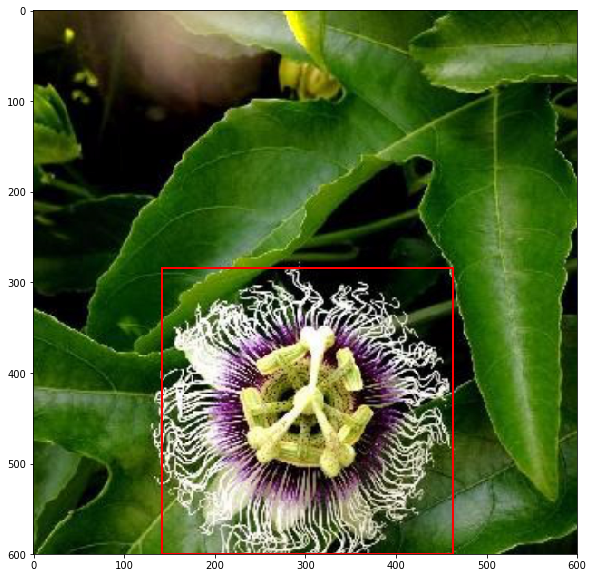

In [7]:
t = queue.get()
blobs = t.next()
gt_boxes = blobs[0]['boxes']
gt_classes = blobs[0]['gt_classes']
imshow(blobs[0]['tensor'][0], gt_boxes)

In [8]:
max_height = np.max([blob['tensor'].shape[2] for blob in blobs])
max_width = np.max([blob['tensor'].shape[3] for blob in blobs])
batch_tensor = torch.Tensor(batch_size, 3, max_height, max_width).fill_(0.)
total_boxes = 0
batch_boxes = np.empty((0, 5))
batch_boxes_index = np.empty((0,), dtype=np.int)
im_info = np.array([[batch_tensor.shape[2], batch_tensor.shape[3]]])
for i, blob in enumerate(blobs):
    shape = blob['tensor'].shape
    batch_tensor[i,:, :shape[2], :shape[3] ] = blob['tensor']
    total_boxes = blob['boxes'].shape[0]
    gt_classes =  blob['gt_classes']
    gt_boxes = np.hstack([blob['boxes'] , gt_classes[:, np.newaxis]])
    batch_boxes = np.vstack((batch_boxes, gt_boxes))
    a =  np.zeros((total_boxes , ), dtype=np.int)
    a.fill(i)
    batch_boxes_index = np.concatenate((batch_boxes_index, a), axis=0)

In [9]:
batch_tensor.shape

torch.Size([3, 3, 600, 600])

In [5]:
categories = ds.classes
print(categories)

['__background__', u'276', u'723']


In [6]:
net = FastRCNN(categories, debug=False)
net.cuda()
net.train()

/opt/conda/envs/pytorch/lib/python2.7/site-packages/torch/nn/parallel/data_parallel.py:24: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 0 which
    has less than 75% of the memory or cores of GPU 1. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
faster_rcnn/network.py:26: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(self.conv.weight)
faster_rcnn/network.py:54: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(self.fc.weight)


FastRCNN(
  (rpn): RPN(
    (features): DataParallel(
      (module): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (6): ReLU(inplace)
        (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): ReLU(inplace)
        (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): ReLU(inplace)
        (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (13): ReLU(inplace)
        (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (15): 

In [12]:
params = filter(lambda x: x.requires_grad, net.parameters())

In [13]:
def train(data_gen, optimizer, lr_scheduler ,model, epochs, steps_per_epoch):
    model.train()
    train_loss = 0
    cross_entropy = 0
    loss_box = 0
    rpn_loss = 0

            
    for step in range(1, steps_per_epoch +1):
        lr_scheduler.step()        
        try:
            blobs = data_gen.next()
            max_height = np.max([blob['tensor'].shape[2] for blob in blobs])
            max_width = np.max([blob['tensor'].shape[3] for blob in blobs])
            batch_tensor = torch.Tensor(batch_size, 3, max_height, max_width).fill_(0.)
            total_boxes = 0
            batch_boxes = np.empty((0, 5))
            batch_boxes_index = np.empty((0,), dtype=np.int)
            im_info = np.array([[batch_tensor.shape[2], batch_tensor.shape[3]]])
            for i, blob in enumerate(blobs):
                shape = blob['tensor'].shape
                batch_tensor[i,:, :shape[2], :shape[3] ] = blob['tensor']
                total_boxes = blob['boxes'].shape[0]
                gt_classes =  blob['gt_classes']
                gt_boxes = np.hstack([blob['boxes'] , gt_classes[:, np.newaxis]])
                batch_boxes = np.vstack((batch_boxes, gt_boxes))
                a =  np.zeros((total_boxes , ), dtype=np.int)
                a.fill(i)
                batch_boxes_index = np.concatenate((batch_boxes_index, a), axis=0)
            
            
            cls_prob, bbox_pred, rois = model(batch_tensor, im_info, batch_boxes, batch_boxes_index)
        except Exception as e:
            print batch_boxes_index
            print e
            continue


        cls_data = cls_prob.data.cpu().numpy()
        max_class_idx = np.argmax(cls_data, axis=1)
        loss = model.loss
        cross_entropy += model.cross_entropy.item()
        loss_box += model.loss_box.item()
        train_loss += loss.item()
        rpn_loss += model.rpn.loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % 10 == 0:
            log_text = 'step %d,  loss: %.4f' % (
                step, train_loss /(step))
            print(log_text)

            re_cnt = True


        if step % 10 == 0:
            torch.save(model.state_dict(), 'faster_model_at_step_%s.pkl' % step)
    return blobs

In [14]:
optimizer = SGD(params, lr=1e-4, momentum=0.9, weight_decay=0.0005)
exp_lr_scheduler = StepLR(optimizer, step_size=1000, gamma=0.8)

In [ ]:
train(t, optimizer=optimizer,lr_scheduler=exp_lr_scheduler, model=net, epochs=1, steps_per_epoch=1500)

faster_rcnn/faster_rcnn.py:169: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  cls_prob = F.softmax(cls_score)


step 10,  loss: 5.1530
step 20,  loss: 4.2981
step 30,  loss: 3.8146
step 40,  loss: 3.4193
step 50,  loss: 3.1817
step 60,  loss: 3.0139
step 70,  loss: 2.8798
[0 1]
attempt to get argmax of an empty sequence
step 80,  loss: 2.7508
step 90,  loss: 2.6682
step 100,  loss: 2.6141
step 110,  loss: 2.5584
step 120,  loss: 2.5129
step 130,  loss: 2.4706
step 140,  loss: 2.4297
step 150,  loss: 2.4012
step 160,  loss: 2.3622
[0 1]
attempt to get argmax of an empty sequence
step 170,  loss: 2.3216
step 180,  loss: 2.2968
step 190,  loss: 2.2702
step 200,  loss: 2.2475
step 210,  loss: 2.2193
step 220,  loss: 2.1963
step 230,  loss: 2.1720
step 240,  loss: 2.1537
[0 1 1]
attempt to get argmax of an empty sequence
step 250,  loss: 2.1205
step 260,  loss: 2.0977
step 270,  loss: 2.0750
step 280,  loss: 2.0584
step 290,  loss: 2.0369
step 300,  loss: 2.0135
step 310,  loss: 1.9920
step 320,  loss: 1.9728
[0 1]
attempt to get argmax of an empty sequence
step 330,  loss: 1.9522
step 340,  loss: 1.

In [11]:
weights = torch.load('./faster_model_at_step_1290.pkl')
net.load_state_dict(weights)

In [ ]:
optimizer = SGD(params, lr=1e-5, momentum=0.9, weight_decay=0.0005)
exp_lr_scheduler = StepLR(optimizer, step_size=1000, gamma=0.92)

In [ ]:
train(t, t2, optimizer=optimizer,lr_scheduler=exp_lr_scheduler, model=net, epochs=1, steps_per_epoch=100000)

In [12]:
net.detect("./test_im/harry-meghan-15.jpg")

(array([[100.66250818, 241.43213722, 604.3136253 , 582.69908549],
        [508.22515504, 474.08870507, 998.77014599, 599.        ],
        [444.71935716,   0.        , 600.56142801, 258.09001212],
        [734.271296  , 329.92127016, 885.46753212, 486.57025034],
        [656.03265952, 176.00919804, 747.31255975, 204.38666904]]),
 array([0.8598545 , 0.77978283, 0.61261463, 0.5910712 , 0.5162496 ],
       dtype=float32),
 array([u'276', u'276', u'276', u'276', u'276'], dtype='<U14'),
 array([[ 667.38196 ,  432.41888 , 1028.5662  ,  599.      ],
        [ 280.42313 ,  305.00787 ,  651.5543  ,  599.      ],
        [ 672.1464  ,  454.026   , 1079.3376  ,  599.      ],
        [ 211.58673 ,  311.83057 ,  688.56    ,  599.      ],
        [ 619.5292  ,  409.73953 , 1023.17993 ,  599.      ],
        [ 249.76611 ,  430.27582 ,  658.131   ,  599.      ],
        [ 199.86441 ,  172.70927 ,  722.80164 ,  599.      ],
        [ 648.987   ,  357.052   , 1060.7725  ,  599.      ],
        [ 249.30

In [23]:
def result_show(inp, predicted_boxes=[], classes=[], scores=[]):
    font = ImageFont.truetype(font ='./font/FiraMono-Medium.otf', size=np.floor(3e-2 * 600 + 0.5).astype('int32'))
    
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    inp *= 255.0/inp.max() 
    
    fig,ax = plt.subplots(1, figsize=(20, 10))
    
    image = Image.fromarray(inp.astype('uint8'))
    
    draw = ImageDraw.Draw(image)
    for predicted_box, predicted_class, score in zip(predicted_boxes, classes, scores):
        label = '{} {:.2f}'.format(predicted_class, score)

        
        label_size = draw.textsize(label, font)
        
        left, top, right, bottom = predicted_box
        print(predicted_class, (left, top), (right, bottom))
        
        for i in range(3):
            draw.rectangle(
                [left + i, top + i, right - i, bottom - i],
                outline=(255,255,0))
        if top - label_size[1] >= 0:
            text_origin = np.array([left, top - label_size[1]])
        else:
            text_origin = np.array([left, top + 1])
        draw.rectangle(
                [tuple(text_origin), tuple(text_origin + label_size)])
        draw.text(text_origin, label, fill=(255, 255, 0), font=font)
    del draw
    ax.imshow(image)

In [56]:
pred_boxes, scores, classes, rois, blob = net.detect('./test_im/1499006947009_thum_1499006946448_thum_photo.jpg', thr=0.9)


(u'276', (128.96043095148045, 114.03004330333357), (460.21950352273075, 536.0740374519571))


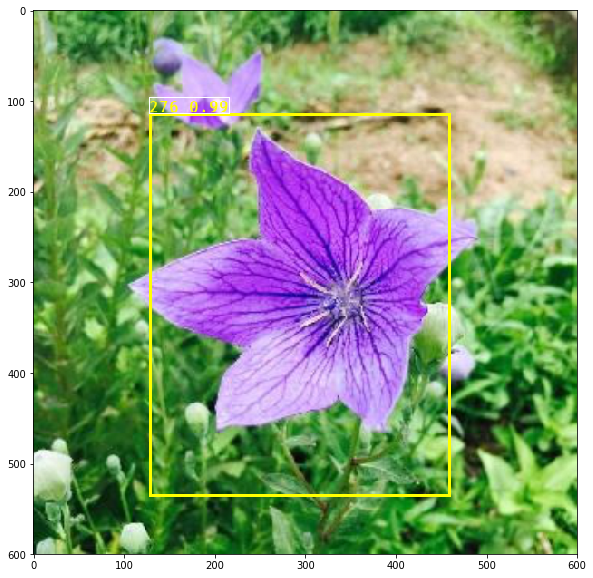

In [57]:
result_show(blob[0], pred_boxes,classes, scores)